In [1]:
import pandas as pd
import numpy as np
import datetime
from time import ctime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos de entrenamiento limpios y con features agregados
train = pd.read_csv('../data/to_train_01.csv', low_memory=False, lineterminator='\n')

print(train.info())
train.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 110 entries, building_id to position_o
dtypes: bool(22), float64(35), int64(53)
memory usage: 180.4 MB
None


,building_id,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,legal_ownership_status_w,ground_floor_type_f,ground_floor_type_x,ground_floor_type_v,ground_floor_type_z,ground_floor_type_m,position_t,position_s,position_j,position_o\r
0,802906,3,2,30,6,5,True,True,False,False,...,0,1,0,0,0,0,1,0,0,0


In [3]:
# Datos de prueba
test = pd.read_csv('../data/to_test_01.csv', low_memory=False, lineterminator='\n')
print(test.info())
test.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Columns: 109 entries, building_id to cant_materiales
dtypes: bool(1), float64(35), int64(73)
memory usage: 71.7 MB
None


,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,300051,3,20,7,6,0,1,0,0,0,...,0.285714,1.166667,42,49,36,6.5,0.333333,0.142857,0.166667,1


## Entrenamiento del modelo

### Seleccion de features

In [4]:
def seleccion_de_features_to_remove(df_train):
    '''
    Funcion para seleccionar features.
    features_to_remove es la base que contiene building_id y damage_grade
    Las demas listas, las creamos y las agregamos a subset_features para luego appendearlas a features_to_remove
    '''
    features_to_remove = ['building_id', 'damage_grade']
    subset_features = []
    has_secondary = [col for col in df_train.columns if 'has_secondary' in col]
    legal_ownership = [col for col in df_train.columns if 'legal_ownership' in col]
    plan_configuration = [col for col in df_train.columns if 'plan_configuration' in col]
    probas = [col for col in df_train.columns if 'proba_danio' in col]
    relaciones_geo = [col for col in df_train.columns if 'relacion_' in col]
    cantidad_geo = [col for col in df_train.columns if 'cant_geolevel' in col]
    subset_features.append(has_secondary)
    subset_features.append(cantidad_geo)
    subset_features.append(legal_ownership)
    subset_features.append(relaciones_geo)
    #subset_features.append(probas)
    #subset_features.append(plan_configuration)
    for subset in subset_features:
        features_to_remove += subset
    return features_to_remove

In [5]:
features_to_remove = seleccion_de_features_to_remove(train)
Y = train['damage_grade']
X = train.drop(features_to_remove, axis=1)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208480 entries, 170377 to 121958
Data columns (total 85 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     208480 non-null  int64  
 1   age                                     208480 non-null  int64  
 2   area_percentage                         208480 non-null  int64  
 3   height_percentage                       208480 non-null  int64  
 4   has_superstructure_adobe_mud            208480 non-null  bool   
 5   has_superstructure_mud_mortar_stone     208480 non-null  bool   
 6   has_superstructure_stone_flag           208480 non-null  bool   
 7   has_superstructure_cement_mortar_stone  208480 non-null  bool   
 8   has_superstructure_mud_mortar_brick     208480 non-null  bool   
 9   has_superstructure_cement_mortar_brick  208480 non-null  bool   
 10  has_superstructure_timber              

### Entrenamiento

In [8]:
# Del mejor submit en DrivenData fue:
# El mejor score de RandomForest con GridSearchCV fue: 0.7605
# Training Score: 0.8058
# Test Score:  0.7603
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

best_params = {
    'min_samples_split':60, 
    'n_estimators':500,
    'n_jobs':-1
}

min_features_to_select = 40
print('Hora antes de empezar a tunear/entrenar: {}'.format(ctime()))
model = RandomForestClassifier(**best_params)
rfecv = RFECV(model, step=2, cv=4, scoring='f1_micro', min_features_to_select=min_features_to_select, verbose=10, n_jobs=-1)
rfecv.fit(X_train, y_train)
print('Hora al finalizar de tunear/entrenar: {}'.format(ctime()))

# Vemos el score comprobando contra el set de test y de train
y_pred_test = rfecv.predict(X_test)
model_f1_micro_test = f1_score(y_test, y_pred_test, average='micro')
y_pred_train = rfecv.predict(X_train)
model_f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
print("Training Score: %.4f" % model_f1_micro_train)
print("Test Score:  %.4f" % model_f1_micro_test)

Hora antes de empezar a tunear/entrenar: Sun Jul 11 23:12:00 2021
Hora al finalizar de tunear/entrenar: Mon Jul 12 01:17:13 2021


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

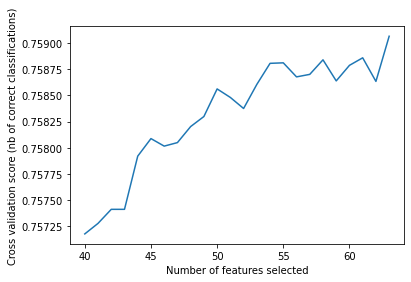

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

### Feature importance

> https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

>https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

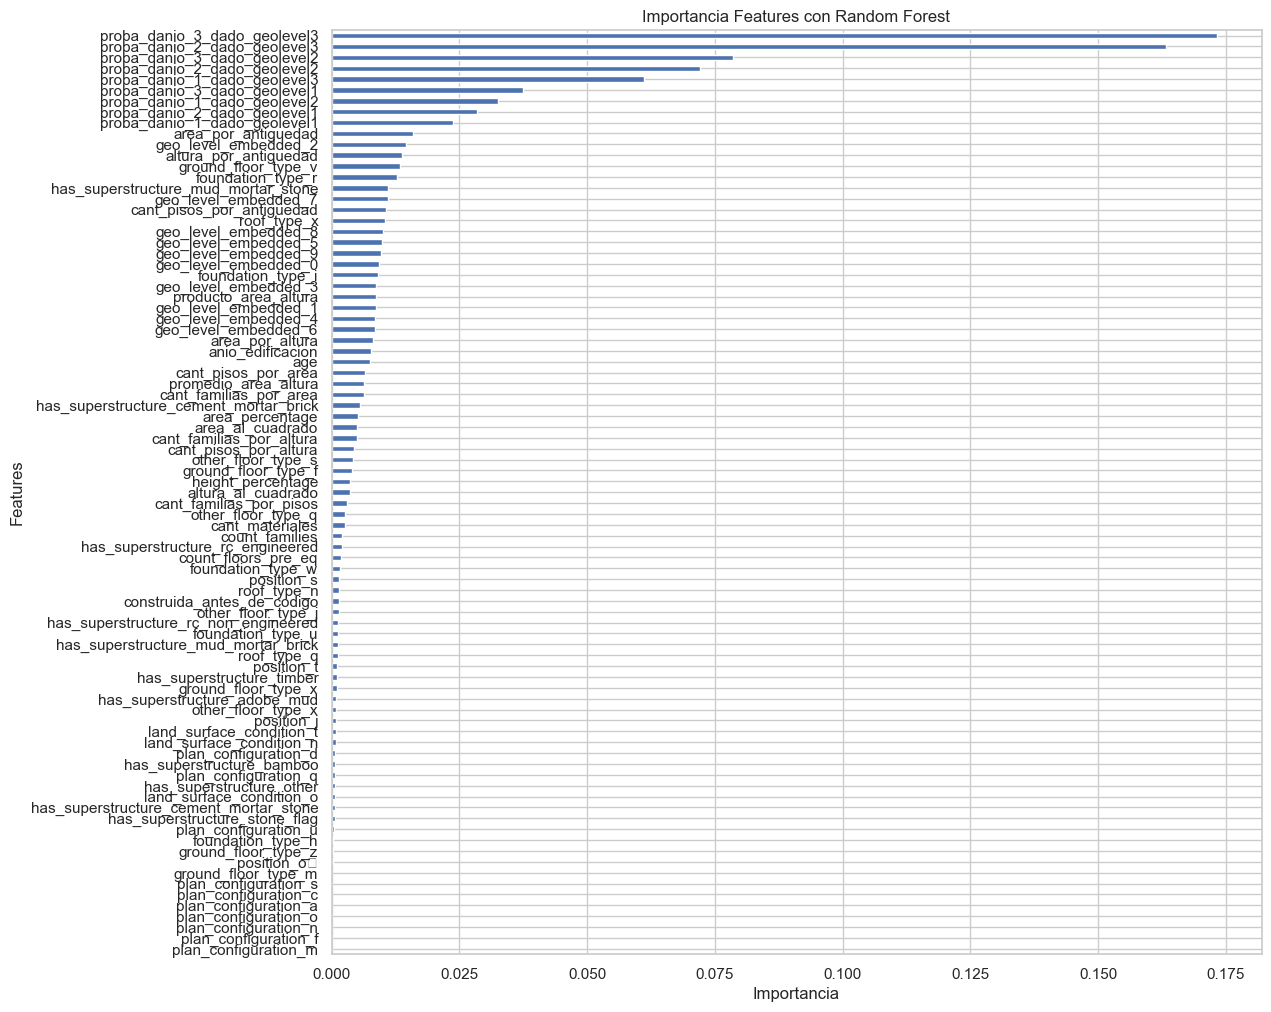

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid") # seteando tipo de grid en seaborn

feature_cols = X.columns.tolist()
features = pd.Series(data=model.feature_importances_, index=feature_cols, name='Feature importance')
features.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(12, 12))
features.plot(kind='barh')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.title('Importancia Features con Random Forest')
plt.show()

La matriz de confusion nos muestra nuestros $tp$, $fp$, $tn$ y $fn$ en una matriz. La diagonal principal son los valores correctamente clasificados. Los otros valores indican la cantidad de puntos mal clasificados.
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("Label correcto")
    plt.xlabel("Label predecido")
    plt.show()

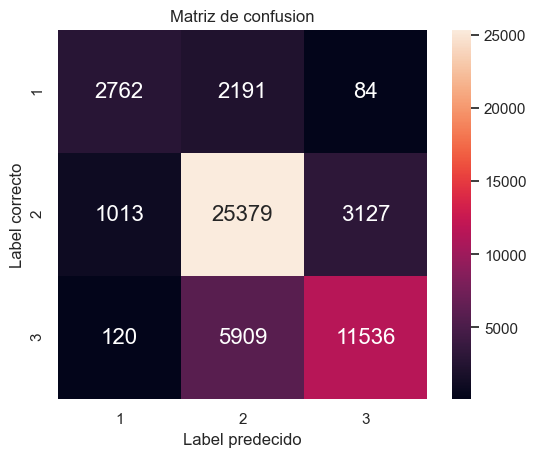

In [28]:
plot_confusion_matrix(y_test, y_pred_test)

### Prediccion del modelo

In [29]:
# Saco damage_grade de las features a remover ya que dicha feature NO esta en el set de test
features_to_remove.remove('damage_grade')
to_test = test.drop(features_to_remove, axis=1)

In [30]:
y_pred = model.predict(to_test)
y_pred

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)

### Formateo de la prediccion para un submit

In [31]:
test_id = test['building_id']
test_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64

In [32]:
submit = pd.concat([test_id, pd.Series(y_pred, name='damage_grade')], axis=1)
submit.set_index('building_id', inplace=True)
submit.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,2
421793,3


In [33]:
submit.to_csv('../submits-csv/submit-RandomForest-{}.csv'.format(model_f1_micro_test))